# Data mining techniques: Assignment 2

## LambdaMART model training and evaluation

In [4]:
# Definitely used
library("ggplot2")
library("scales")
library("plyr")
library("gbm")
library("StatRank")

# Not completely sure about these. 
# Let me run without these to see if an error shows up
#library("dplyr")
#library("grid")
#library("gridExtra")

# Scoring and Ranking functions

In [1]:
rank_prediction <- function(df){
    "
    Ranks search IDs according to prediction scores

    The dataframe given as a parameter 
    must contain the following columns
    in order to rank:
        - srch_id (the search IDs)
        - prediction (the prediction per row (higher score -> better rank))

    Other important columns are:
        - prop_id (for sorting the property IDs for the prediction file)
        - relevance (relevance score for calculating the NDCG of the test set)
    "
    
    res <- df[order(df$srch_id,df$prediction,decreasing=c(FALSE,TRUE)),]
    
    rownames(res) <- NULL
    
    return(res)
}

ndcg_score <- function(i,data){
    #group <- data[data[,"srch_id"] == i,]
    group <- subset(data,srch_id == i)
    
    #dcg <- (2^group[,"relevance"] - 1) / log2((1:nrow(group))+1)
    #idcg <- (2^group[order(group$relevance,decreasing=TRUE),"relevance"] - 1) / log2((1:nrow(group))+1)
    #return(sum(dcg) / sum(idcg))
    
    return(Evaluation.NDCG(nrow(group):1,group[,"relevance"]))
}

ndcg_mean <- function(df){
    "
    Calculates the average ndcg score for a 
    given ensemble of ranked searches.

    The dataframe given as a parameter 
    must contain the following columns
    in order to calculate the ndcg score:
        - srch_id (the search IDs)
        - relevance (relevance score for calculating the NDCG of the test set)
    "

    ndcg <- sapply(unique(df[,"srch_id"]),data=df,FUN=ndcg_score)
    return(mean(ndcg,na.rm = TRUE))
}

In [3]:
# Test implementation

set.seed(1234)

srch_id <- c(rep(1,6),rep(2,6),3)
prop_id <- 1:13
prediction <- c(4,3,5,6,1,2,sample(1:6,replace=F),1)
relevance <- c(5,1,1,0,0,0,sample(c(5,1,0,0,0,0),replace=F),0)

df <- data.frame(srch_id=srch_id,prop_id=prop_id,prediction=prediction,relevance=relevance)

df

ranking <- rank_prediction(df)

ranking

ndcg_mean(ranking)

srch_id,prop_id,prediction,relevance
1,1,4,5
1,2,3,1
1,3,5,1
1,4,6,0
1,5,1,0
1,6,2,0
2,7,1,5
2,8,4,1
2,9,3,0
2,10,2,0


srch_id,prop_id,prediction,relevance
1,4,6,0
1,3,5,1
1,1,4,5
1,2,3,1
1,6,2,0
1,5,1,0
2,12,6,0
2,11,5,0
2,8,4,1
2,9,3,0


[1] 0.4401753

# Load the data

In [4]:
# Memory efficient column specific data frame loading functions
col_list <- function(names,selected,df){
    res <- c(1:length(names))
    res[] <- "NULL"
        
    for(i in 1:length(selected)){
        res[names == selected[i]] <- df[selected[i],1]
    }
    
    return(res)
}

load_part <- function(path,nrows = -1,skip = 1,colClasses = NA){
    namecols <- colClasses
    if(length(namecols) > 1 || !is.na(namecols)){
        namecols[colClasses != "NULL"] <- NA
    }
    
    names <- colnames(read.csv(trainPath,nrows = 1,colClasses=namecols))
    df <- read.csv(trainPath,header=F,skip=skip,nrows = nrows,colClasses=colClasses,
                   na.strings=c("NA","NULL"))
    
    colnames(df) <- names
    
    return(df)
}

In [5]:
# Set file paths and columns
trainPath <- "/home/kevin/data_mining/data/assignment2/Balanced_Data/underTrain.csv"
validPath <- "/home/kevin/data_mining/data/assignment2/Balanced_Data/underValidation.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/split_data_dm/mod_test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))
testNames <- colnames(read.csv(testPath,nrows = 1))

# Initialize types to numeric
types <- c(1:length(trainNames))
types[] <- "numeric"

# Initialize type dataframe
types <- data.frame(types=types,stringsAsFactors=FALSE)
rownames(types) <- trainNames

# Set types manually
#factors <- c("site_id","prop_country_id","prop_id","srch_destination_id","date_month","date_year")

#types[factors,] <- "factor"

types

,types
srch_id,numeric
site_id,numeric
prop_country_id,numeric
prop_id,numeric
prop_starrating,numeric
prop_review_score,numeric
prop_brand_bool,numeric
prop_location_score2,numeric
prop_log_historical_price,numeric
position,numeric


In [6]:
# Load the data with the correct attributes

columns <- col_list(trainNames,trainNames,types)

train <- read.csv(trainPath,colClasses=columns)
valid <- read.csv(validPath,colClasses=columns)

columns <- col_list(testNames,trainNames,types)
test <- read.csv(testPath,colClasses=columns)

In [7]:
head(train)
head(test)

srch_id,site_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score2,prop_log_historical_price,position,⋯,date_year,starrating_diff,usd_diff,price_rank,star_rank,relevance,room_count,persons_count,ignored_bool,prop_starrating_monotonic
49768,5,219,59673,3,4.5,1,0.0599,0.00,7,⋯,2013,0,0,11,2,0,993,38,1,0.3130997
49768,5,219,97076,3,4.5,1,0.0458,0.00,2,⋯,2013,0,0,16,2,1,993,38,0,0.3130997
49769,5,55,11473,4,4.0,1,0.0824,0.00,3,⋯,2013,0,0,11,2,5,545,18,0,0.6869003
49770,5,219,39608,2,4.0,1,0.1800,4.42,2,⋯,2013,0,0,1,3,5,528,20,0,1.3130997
49770,5,219,138300,2,4.0,1,0.1421,4.42,21,⋯,2013,0,0,6,3,0,528,20,1,1.3130997
49771,5,219,43367,3,4.5,1,0.3531,0.00,1,⋯,2013,0,0,11,1,1,520,18,0,0.3130997


srch_id,site_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score2,prop_log_historical_price,position,⋯,date_year,starrating_diff,usd_diff,price_rank,star_rank,relevance,room_count,persons_count,ignored_bool,prop_starrating_monotonic
1,12,219,893,3,3.5,1,0.0438,4.95,27,⋯,2013,0,0,3,2,0,492,36,1,0.3130997
1,12,219,10404,4,4.0,1,0.0149,5.03,26,⋯,2013,0,0,14,1,0,492,36,1,0.6869003
1,12,219,21315,3,4.5,1,0.0245,4.92,21,⋯,2013,0,0,15,2,0,492,36,1,0.3130997
1,12,219,27348,2,4.0,1,0.0125,4.39,34,⋯,2013,0,0,22,3,0,492,36,1,1.3130997
1,12,219,29604,4,3.5,1,0.1241,4.93,4,⋯,2013,0,0,11,1,0,492,36,1,0.6869003
1,12,219,30184,4,4.5,1,0.1302,5.20,7,⋯,2013,0,0,19,1,0,492,36,1,0.6869003


# Model training

In [100]:
# Set rng seed for reproducible results
set.seed(1234)

## Train lambdaMART using GBM

In [101]:
# Get training and testing subsets
gbm.train <- subset(train, select=c(-position,-click_bool,-gross_bookings_usd,-booking_bool,-ignored_bool))
gbm.test <- subset(test, select=c(-position,-click_bool,-gross_bookings_usd,-booking_bool,-ignored_bool))

# Generate the attribute string for the formula (all columns except srch_id and relevance)
remove <- c("srch_id","relevance")
attributes <- colnames(gbm.train)
attributes <- attributes[! attributes %in% remove]
attributes <- paste(attributes,collapse="+")

# Construct the formula for model input
train.formula <- paste("relevance","~",attributes,collapse="")
train.formula <- as.formula(train.formula)

# Set number of trees
tree_num <- 20000

# Train the GBM LambdaMART model
gbm.model <- gbm(train.formula,
                data=gbm.train,
                distribution=list(   # loss function:
                  name='pairwise',   # pairwise
                  metric="ndcg",     # ranking metric:
                  group="srch_id"),    # column indicating query groups
                n.trees=tree_num,         # number of trees
                train.fraction=0.8,   # Fraction of training data used
                keep.data = TRUE,      # store copy of input data in model
                verbose = FALSE)     # don't print progress

rm(gbm.train)

In [102]:
# Train more trees if needed
if(FALSE){
    num <- 10000
    gbm.model <- gbm.more(gbm.model,n.new.trees = num,verbose=TRUE)
    tree_num <- tree_num + num
}

# Model evaluation

[1] 19142


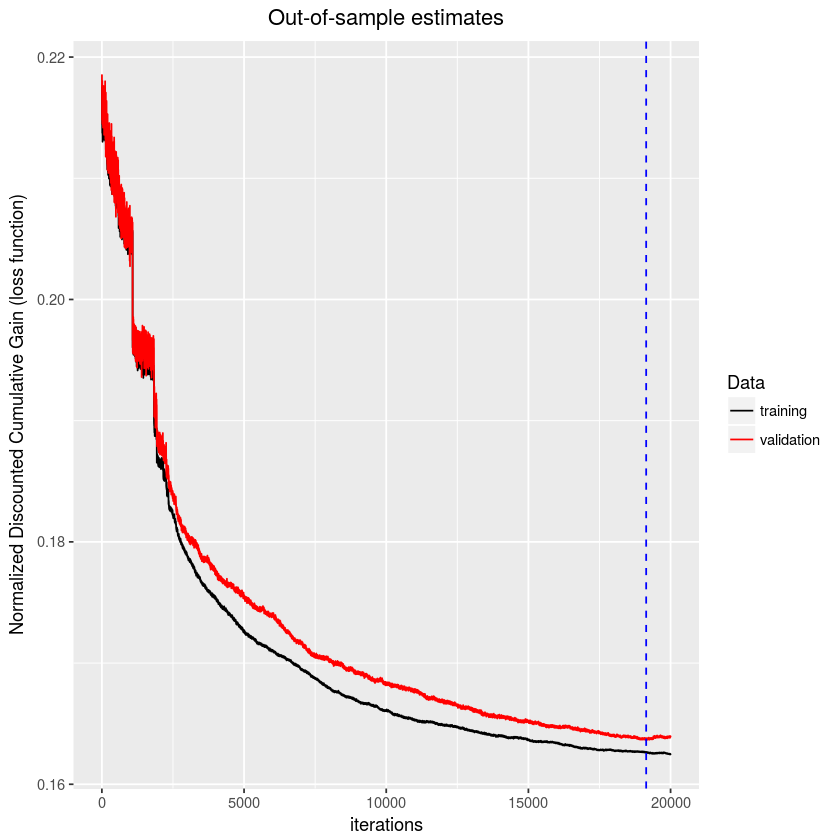

In [136]:
# Get best iteration using Out-Of-Sample estimate (see documentation on gbm.perf method "test")
best.iter <- gbm.perf(gbm.model, plot.it=FALSE, method="test")

print(best.iter)

# Make a pretty plot of the performance curve
df <- rbind(data.frame(error=gbm.model$train.error,
                       iterations=c(1:length(gbm.model$train.error)),name="training"),
            data.frame(error=gbm.model$valid.error,
                       iterations=c(1:length(gbm.model$valid.error)),name="validation"))

ggplot(df,aes(x=iterations,y=error,colour=name)) + geom_line() +
scale_color_manual(values=c("black", "red")) +
geom_vline(aes(xintercept=best.iter),linetype="dashed",colour="blue") +
theme(plot.title = element_text(hjust = 0.5)) + 
labs(title="Out-of-sample estimates", x="iterations", 
     y="Normalized Discounted Cumulative Gain (loss function)",colour="Data")

In [163]:
# Predict test set using the trained model
predictions <- predict(gbm.model,gbm.test,n.trees=best.iter)

# Construct data.frame with correct format and columns
predictions.df <- data.frame(srch_id=as.numeric(as.character(gbm.test$srch_id)),
                             prop_id=as.numeric(as.character(gbm.test$prop_id)),
                             prediction=predictions,relevance=gbm.test$relevance)

print("Now ranking")

ranking <- rank_prediction(predictions.df)

ranking

print("Now scoring")

ndcg_mean(ranking)

[1] "Now ranking"


srch_id,prop_id,prediction,relevance
1,88218,1.01492880,0
1,88096,0.78402602,0
1,53341,0.73278108,0
1,95307,0.66035291,0
1,29604,0.63735472,0
1,30184,0.34477862,0
1,59526,0.28195844,0
1,893,0.27228648,0
1,95166,0.08180149,0
1,56880,-0.03307467,0


[1] "Now scoring"


[1] 0.4877352

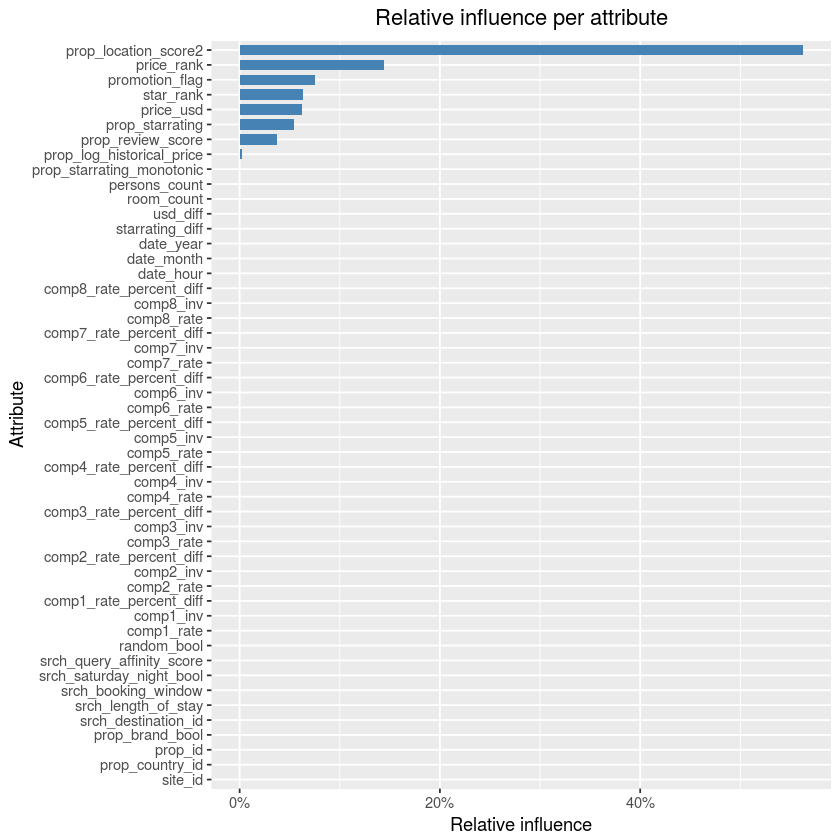

In [105]:
# Get relative influence from summary 
# (see documentation on relative influence for summary.gbm function by method)
model.summary <- summary(gbm.model,plotit=FALSE,n.trees=best.iter)

positions <- arrange(model.summary,rel.inf)["var"][,1]

ggplot(data=model.summary,aes(x=factor(var),y=rel.inf/100)) + 
geom_bar(stat="identity",width=0.7, fill="steelblue") + coord_flip() +
theme(axis.text.x = element_text(angle = 0, hjust = 0.5), plot.title = element_text(hjust = 0.5)) + 
scale_x_discrete(limits=positions) + scale_y_continuous(labels=percent) +
labs(title="Relative influence per attribute", x="Attribute", y="Relative influence")